<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/ResorviorComputing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[DATA] train=1500  val=500  test=1000
[ESN ] N_RES=300  leak=0.3  rho=0.9  sparsity=0.1  washout=100
[SHAPES] val_pred=(399,), test_pred=(899,)
[THRESH] mode=quantile  pct=99.7  alpha=0.2  persist_k=3  -> thr=0.089052
[EVAL] AUC=0.9832  AP=0.9072  Acc@thr+persist=0.8877


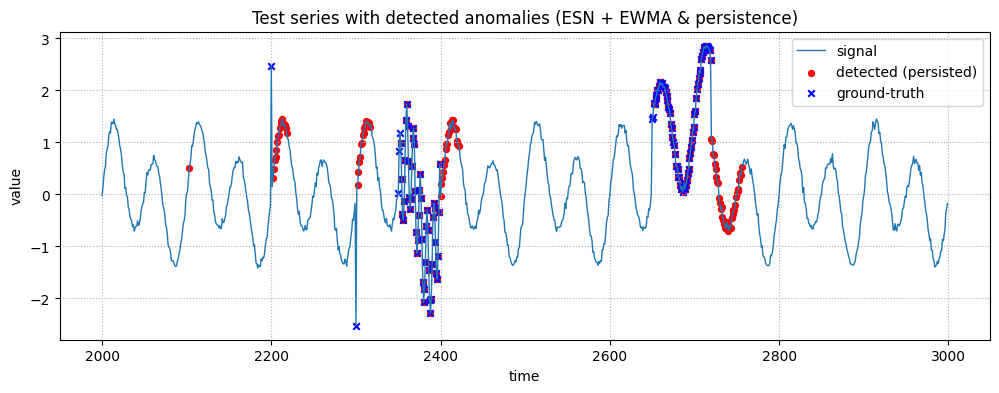

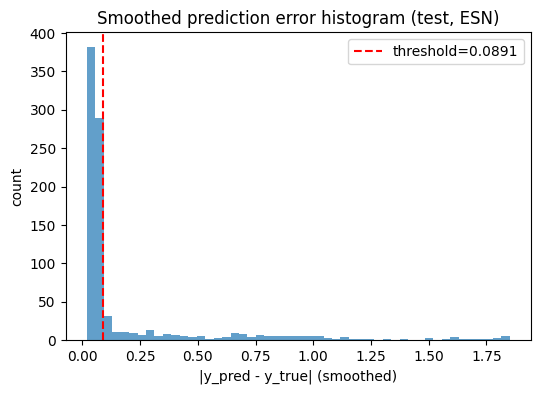

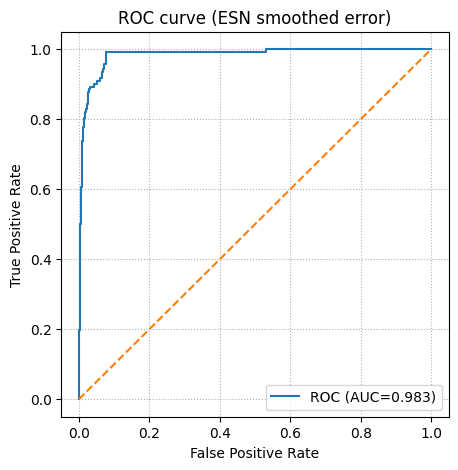


Notes:
- This ESN trains a linear readout with ridge regression on teacher-forced reservoir states (normal-only).
- Anomaly score = absolute one-step prediction error (optionally EWMA-smoothed).
- Threshold from validation-normal via quantile or robust MAD; persistence filter reduces false positives.
- Tune: THRESH_PCT↑ / MAD_SCALE↑ for fewer FPs; increase PERSIST_K; adjust SMOOTH_ALPHA; change reservoir size or spectral radius.



In [1]:
# Colab one-cell: Reservoir Computing (Echo State Network) による時系列異常検知
# 目的
# - LSTM 例と同じ合成データ（学習=正常のみ、検証=正常、テスト=正常+異常）を使用
# - ESN（リザバーコンピューティング）で次時点予測を学習し、予測誤差で異常検知
# - 過検出対策: 誤差の EWMA 平滑化 + 連続検出 (persistence) + 分位点/MAD しきい値
# 表示
# - コメントは日本語、グラフのキャプション等は英語

import numpy as np, matplotlib.pyplot as plt

# 評価指標（未インストールなら導入）
try:
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc
except Exception:
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "-q", "install", "scikit-learn"])
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc

# ===== ハイパーパラメータ =====
SEED = 42
rng = np.random.default_rng(SEED)

# データ長・分割
N = 3000                 # 全系列長
TR_END = 1500            # 学習終了インデックス（[0, TR_END)）
VAL_END = 2000           # 検証終了インデックス（[TR_END, VAL_END)）
TE_END  = N              # テスト終了インデックス（[VAL_END, TE_END)）

# ESN（リザバー）設定
N_RES   = 300            # リザバー（隠れ）ユニット数
LEAK    = 0.3            # リーク率（leaky-integrator）
RHO     = 0.9            # スペクトル半径（安定性と表現力のバランス）
SPARSITY= 0.1            # リカレント結合の疎度
IN_SCALE= 1.0            # 入力スケール（Win の振幅）
RIDGE   = 1e-2           # 読み出しのリッジ回帰係数
WASHOUT = 100            # ウォームアップ（状態捨て期間）

# 過検出対策（しきい値/平滑/連続）
THRESH_MODE = "quantile" # "quantile" または "mad"
THRESH_PCT  = 99.7       # 分位点（厳しめ: 99.5〜99.9）
MAD_SCALE   = 3.5        # MAD のスケール（3.0〜4.5）
SMOOTH_ALPHA = 0.2       # EWMA 平滑（0 で無効, 0.1〜0.4 推奨）
PERSIST_K    = 3         # 連続 K 点以上で異常とみなす

# ===== 合成データ（正常 + 異常） =====
# 正常: 複合サイン + わずかなノイズ
t = np.arange(N)
x = (np.sin(2*np.pi*t/50) + 0.5*np.sin(2*np.pi*t/100) + 0.05*rng.standard_normal(N)).astype(np.float32)

# 異常ラベル（0=正常, 1=異常）
labels = np.zeros(N, dtype=int)

# テスト区間に異常を注入（尖り, レベルシフト, 周波数バースト）
def add_spike(idx, amp):
    x[idx] += amp; labels[idx] = 1
def add_level_shift(start, end, shift):
    x[start:end] += shift; labels[start:end] = 1
def add_freq_burst(start, end, amp=1.0, period=10):
    x[start:end] += amp*np.sin(2*np.pi*np.arange(end-start)/period); labels[start:end] = 1

# 学習/検証は正常のみ、テストに異常を入れる
add_spike(2200, +2.5)
add_spike(2300, -2.5)
add_freq_burst(2350, 2400, amp=1.0, period=8)
add_level_shift(2650, 2720, shift=+1.5)

# ===== 標準化（学習区間の統計のみ使用） =====
mu = x[:TR_END].mean().item()
sd = x[:TR_END].std().item() + 1e-8
xz = (x - mu) / sd

# ===== ESN 実装 =====
class ESN:
    """1次元入力 → 1次元出力（次時点予測）"""
    def __init__(self, n_res=300, leak=0.3, rho=0.9, sparsity=0.1, in_scale=1.0, ridge=1e-2, seed=42):
        self.n_res = n_res
        self.leak = leak
        self.rho  = rho
        self.ridge= ridge
        self.rng  = np.random.default_rng(seed)

        # 入力結合（バイアスを含む: [1; u]）
        self.Win = self.rng.uniform(-in_scale, in_scale, size=(n_res, 1+1)).astype(np.float64)

        # リカレント結合（疎行列をランダム生成 → スペクトル半径スケーリング）
        W = self.rng.uniform(-1.0, 1.0, size=(n_res, n_res)).astype(np.float64)
        mask = self.rng.random((n_res, n_res)) < sparsity
        W *= mask
        # スペクトル半径に合わせてスケーリング
        eigvals = np.linalg.eigvals(W)
        sr = np.max(np.abs(eigvals)).real + 1e-12
        self.W = (W / sr) * rho
        self.Wout = None  # 読み出し（学習後に設定）

    def _step(self, x_prev, u_t):
        """1ステップ状態更新"""
        uvec = np.array([1.0, float(u_t)], dtype=np.float64)           # バイアス+入力
        pre = self.Win @ uvec + self.W @ x_prev
        x_new = (1 - self.leak) * x_prev + self.leak * np.tanh(pre)
        return x_new

    def _run_collect(self, u_seq, washout):
        """教師信号 u(t+1) に対して、u(t) で状態を駆動（teacher forcing）し、状態とターゲットを収集"""
        L = len(u_seq)
        x_state = np.zeros(self.n_res, dtype=np.float64)
        X, Y = [], []
        for t in range(L-1):  # t の状態から y(t) = u(t+1) を予測
            x_state = self._step(x_state, u_seq[t])
            if t >= washout:
                X.append(x_state.copy())
                Y.append(u_seq[t+1])
        if len(X) == 0:
            return np.zeros((0, self.n_res), dtype=np.float64), np.zeros((0,), dtype=np.float64)
        return np.vstack(X), np.array(Y, dtype=np.float64)

    def fit(self, u_train, washout=100):
        """読み出し Wout をリッジ回帰で学習"""
        X, Y = self._run_collect(u_train, washout)
        # バイアス項を結合
        Xa = np.hstack([np.ones((X.shape[0], 1), dtype=np.float64), X])
        # (Xa^T Xa + λI)^{-1} Xa^T Y
        A = Xa.T @ Xa + self.ridge * np.eye(Xa.shape[1], dtype=np.float64)
        b = Xa.T @ Y
        self.Wout = np.linalg.solve(A, b)

    def predict(self, u_seq, start_index, washout=100):
        """次時点予測と対応するグローバル時刻インデックスを返す"""
        assert self.Wout is not None, "Call fit() before predict()."
        X, Y = self._run_collect(u_seq, washout)
        if X.shape[0] == 0:
            return np.array([]), np.array([]), np.array([])
        Xa = np.hstack([np.ones((X.shape[0], 1), dtype=np.float64), X])
        Yhat = Xa @ self.Wout
        # 出力は標準化スケールのまま（学習も標準化上）
        # インデックス: [start+washout+1, start+len(u_seq)-1] を対象
        idx = np.arange(start_index + washout + 1, start_index + len(u_seq), dtype=int)
        return Yhat.astype(np.float64), Y.astype(np.float64), idx

# ===== ESN 学習 =====
esn = ESN(n_res=N_RES, leak=LEAK, rho=RHO, sparsity=SPARSITY, in_scale=IN_SCALE, ridge=RIDGE, seed=SEED)

# 学習（train 区間）
u_train = xz[:TR_END]
esn.fit(u_train, washout=WASHOUT)

# 検証（val 区間）: しきい値決定用（正常のみ）
u_val = xz[TR_END:VAL_END]
pred_va, true_va, idx_va = esn.predict(u_val, start_index=TR_END, washout=WASHOUT)
err_va = np.abs(pred_va - true_va)  # 標準化空間の誤差

# テスト（test 区間）
u_test = xz[VAL_END:TE_END]
pred_te, true_te, idx_te = esn.predict(u_test, start_index=VAL_END, washout=WASHOUT)
err_te = np.abs(pred_te - true_te)

print(f"[DATA] train={TR_END}  val={VAL_END-TR_END}  test={TE_END-VAL_END}")
print(f"[ESN ] N_RES={N_RES}  leak={LEAK}  rho={RHO}  sparsity={SPARSITY}  washout={WASHOUT}")
print(f"[SHAPES] val_pred={pred_va.shape}, test_pred={pred_te.shape}")

# ===== 誤差の平滑化（EWMA） =====
def ewma(x, alpha):
    if alpha <= 0: return x
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i-1]
    return y

err_va_s = ewma(err_va, SMOOTH_ALPHA)
err_te_s = ewma(err_te, SMOOTH_ALPHA)

# ===== しきい値の決定（検証：正常のみ） =====
if THRESH_MODE.lower() == "mad":
    med = np.median(err_va_s)
    mad = np.median(np.abs(err_va_s - med)) + 1e-12
    thr = med + MAD_SCALE * 1.4826 * mad
else:
    thr = np.percentile(err_va_s, THRESH_PCT)

print(f"[THRESH] mode={THRESH_MODE}  pct={THRESH_PCT}  alpha={SMOOTH_ALPHA}  persist_k={PERSIST_K}  -> thr={thr:.6f}")

# ===== 連続検出フィルタ（k 連続で初めて 1） =====
def apply_persistence(scores, thr, k):
    above = (scores >= thr).astype(int)
    if k <= 1 or len(above) == 0: return above
    kernel = np.ones(k, dtype=int)
    conv = np.convolve(above, kernel, mode='valid')
    mask_valid = (conv == k).astype(int)
    mask = np.zeros_like(above)
    mask[k-1:] = mask_valid   # 連続確定の終端に印を置く（簡易実装）
    return mask

# ===== 評価（点ラベルと整合） =====
y_true_pts  = labels[idx_te]             # 真の点異常（0/1）
y_score_pts = err_te_s                   # 異常スコア（平滑後）
y_pred_pts  = apply_persistence(y_score_pts, thr, PERSIST_K)

# AUC/AP/Acc
auc_v = roc_auc_score(y_true_pts, y_score_pts) if len(np.unique(y_true_pts)) > 1 else float("nan")
ap_v  = average_precision_score(y_true_pts, y_score_pts) if len(np.unique(y_true_pts)) > 1 else float("nan")
fpr, tpr, _ = roc_curve(y_true_pts, y_score_pts) if len(np.unique(y_true_pts)) > 1 else (np.array([0,1]), np.array([0,1]), None)
acc = (y_pred_pts == y_true_pts).mean() if len(y_pred_pts)>0 else float("nan")
print(f"[EVAL] AUC={auc_v:.4f}  AP={ap_v:.4f}  Acc@thr+persist={acc:.4f}")

# ===== 可視化 =====
# 1) テスト系列 + 検出点（赤） + 真の異常（青×）
te_range = np.arange(VAL_END, TE_END)
plt.figure(figsize=(12,4))
plt.plot(te_range, x[VAL_END:TE_END], lw=1.0, label="signal")
det_indices = idx_te[y_pred_pts.astype(bool)]
det_in_plot = det_indices - VAL_END
plt.scatter(te_range[det_in_plot], x[det_indices], s=18, c="red", label="detected (persisted)")
gt_in_plot = np.where(labels[VAL_END:TE_END] == 1)[0]
plt.scatter(te_range[gt_in_plot], x[VAL_END:TE_END][gt_in_plot], s=22, marker="x", c="blue", label="ground-truth")
plt.title("Test series with detected anomalies (ESN + EWMA & persistence)")
plt.xlabel("time"); plt.ylabel("value"); plt.legend(); plt.grid(True, linestyle=":")
plt.show()

# 2) 誤差ヒスト + しきい値（平滑後）
plt.figure(figsize=(6,4))
plt.hist(y_score_pts, bins=50, alpha=0.7)
plt.axvline(thr, color="red", linestyle="--", label=f"threshold={thr:.4f}")
plt.title("Smoothed prediction error histogram (test, ESN)")
plt.xlabel("|y_pred - y_true| (smoothed)"); plt.ylabel("count"); plt.legend()
plt.show()

# 3) ROC 曲線（平滑後スコア）
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC curve (ESN smoothed error)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True, linestyle=":")
plt.show()

print("""
Notes:
- This ESN trains a linear readout with ridge regression on teacher-forced reservoir states (normal-only).
- Anomaly score = absolute one-step prediction error (optionally EWMA-smoothed).
- Threshold from validation-normal via quantile or robust MAD; persistence filter reduces false positives.
- Tune: THRESH_PCT↑ / MAD_SCALE↑ for fewer FPs; increase PERSIST_K; adjust SMOOTH_ALPHA; change reservoir size or spectral radius.
""")
